In [224]:
import numpy as np
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [126]:
from utils import helpers as hp
import matplotlib.style as mp_style
mp_style.use('../matplotlibrc')

### Create dataset

In [53]:
with open('model_data/sample_dataset_focused.pkl', 'rb') as file:
    data_set_dict = pickle.load(file)

In [54]:
sentences = data_set_dict['sentences']
labels = data_set_dict['labels']

In [55]:
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))
shuffled_dataset = dataset.shuffle(buffer_size=20000)

#### Split dataset

In [56]:
train_size = int(0.8 * len(dataset))
train_dataset = shuffled_dataset.take(train_size)
test_dataset = shuffled_dataset.skip(train_size)

In [57]:
len(train_dataset), len(test_dataset)

(984, 246)

#### Read in GLoVE

In [8]:
glove_path = '/projects/elopez22/AAW/glove/glove.840B.300d.txt'
glove_embeddings = hp.load_glove_embeddings(glove_path)

#### Prep data for the model

In [58]:
embedding_dim = 300

In [59]:
train_text_data = [x.numpy().decode('utf-8') for x, _ in train_dataset]
test_text_data = [x.numpy().decode('utf-8') for x, _ in test_dataset]

In [60]:
train_label_data = [label.numpy() for _, label in train_dataset]
test_label_data = [label.numpy() for _, label in test_dataset]

2024-12-02 11:27:53.966612: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [61]:
np.unique(train_label_data, return_counts = True)

(array([0, 1], dtype=int32), array([496, 488]))

In [62]:
np.unique(test_label_data, return_counts = True)

(array([0, 1], dtype=int32), array([120, 126]))

In [63]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text_data)
vocab_size = len(tokenizer.word_index) + 1

In [64]:
vocab_size

6133

Convert text to sequences

In [189]:
x_train = tokenizer.texts_to_sequences(train_text_data)
x_test = tokenizer.texts_to_sequences(test_text_data)

pad sequences

In [190]:
max_len = 378
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

Create embedding matrix

In [172]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [161]:
train_labels_cat = to_categorical(train_label_data, num_classes=3) 

In [162]:
test_labels_cat = to_categorical(test_label_data, num_classes=3)

### Model

In [107]:
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False 
    ),
    Bidirectional(LSTM(200)),
    Dense(64, activation='relu'),
    Dense(3, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [173]:
history = model.fit(
    x_train, train_labels_cat,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8479 - loss: 0.2746 - val_accuracy: 0.5025 - val_loss: 0.7019
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9064 - loss: 0.1820 - val_accuracy: 0.4619 - val_loss: 0.8313
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8843 - loss: 0.1848 - val_accuracy: 0.5076 - val_loss: 0.8517
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9235 - loss: 0.1490 - val_accuracy: 0.5025 - val_loss: 0.9919
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9479 - loss: 0.1009 - val_accuracy: 0.4569 - val_loss: 1.1014
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9634 - loss: 0.0651 - val_accuracy: 0.4619 - val_loss: 1.1475
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9785 - loss: 0.0479 - val_accuracy: 0.4924 - val_loss: 1.2412
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9804 - loss: 0.0397 - val_accuracy: 0.4772 - v

In [174]:
determine_model_performance(model, x_test, test_label_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


(array([[63, 57],
        [70, 56]]),
 array([[0.525     , 0.475     ],
        [0.55555556, 0.44444444]]),
 0.483739837398374)

In [175]:
model_1_cm, model_1_cmn,score = determine_model_performance(model, x_test, test_label_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [176]:
model_1_cm

array([[63, 57],
       [70, 56]])

In [177]:
model_1_cmn

array([[0.525     , 0.475     ],
       [0.55555556, 0.44444444]])

In [79]:
score

0.4796747967479675

In [166]:
model_2 = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False  # Freeze embeddings, or set to True to fine-tune
    ),
    Dropout(0.2),  # Add dropout after the embedding layer
    Bidirectional(LSTM(200, return_sequences=False)),
    Dropout(0.2),  # Add dropout after the LSTM layer
    Dense(64, activation='relu'),
    Dropout(0.2),  # Add dropout after the Dense layer
    Dense(3, activation="sigmoid")
])
model_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [167]:
history_2 = model_2.fit(
    x_train, train_labels_cat,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4966 - loss: 0.5461 - val_accuracy: 0.4975 - val_loss: 0.4684
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4932 - loss: 0.4823 - val_accuracy: 0.4924 - val_loss: 0.4691
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5102 - loss: 0.4720 - val_accuracy: 0.4518 - val_loss: 0.4676
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5005 - loss: 0.4706 - val_accuracy: 0.4670 - val_loss: 0.4689
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5005 - loss: 0.4729 - val_accuracy: 0.5025 - val_loss: 0.4723
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5525 - loss: 0.4628 - val_accuracy: 0.4315 - val_loss: 0.4701
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5723 - loss: 0.4574 - val_accuracy: 0.4873 - val_loss: 0.4744
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5983 - loss: 0.4497 - val_accuracy: 0.4315 - v

In [169]:
determine_model_performance(model_2, x_test, test_label_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(array([[44, 76],
        [51, 75]]),
 array([[0.36666667, 0.63333333],
        [0.4047619 , 0.5952381 ]]),
 0.483739837398374)

In [178]:
model_3 = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False  # Freeze embeddings, or set to True to fine-tune
    ),
    Dropout(0.1),  # Dropout after embedding layer
    Bidirectional(LSTM(400, return_sequences=False, 
                       kernel_regularizer=l2(0.01))),  # L2 regularization
    Dropout(0.1),  # Dropout after LSTM
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # L2 on Dense layer
    Dropout(0.1),  # Dropout after Dense layer
    Dense(3, activation="sigmoid", kernel_regularizer=l2(0.01))  # L2 on final Dense
])
model_3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [179]:
history_3 = model_3.fit(
    x_train, train_labels_cat,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5235 - loss: 9.0431 - val_accuracy: 0.5025 - val_loss: 3.0662
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4891 - loss: 2.2987 - val_accuracy: 0.4975 - val_loss: 0.9395
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5117 - loss: 0.8121 - val_accuracy: 0.5025 - val_loss: 0.5995
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5045 - loss: 0.5859 - val_accuracy: 0.5025 - val_loss: 0.5446
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5001 - loss: 0.5447 - val_accuracy: 0.5025 - val_loss: 0.5203
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4901 - loss: 0.5187 - val_accuracy: 0.4975 - val_loss: 0.5098
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4998 - loss: 0.5077 - val_accuracy: 0.4975 - val_loss: 0.5015
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5219 - loss: 0.5006 - val_accuracy: 0.4975 - v

In [180]:
determine_model_performance(model_3, x_test, test_label_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(array([[  0, 120],
        [  0, 126]]),
 array([[0., 1.],
        [0., 1.]]),
 0.5121951219512195)

In [181]:
model_4 = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True  # Freeze embeddings, or set to True to fine-tune
    ),
    LSTM(150),
    Dense(64, activation='relu'),
    Dense(3, activation="sigmoid")
])
model_4.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [191]:
history_4 = model_4.fit(
    x_train, train_labels_cat,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9870 - loss: 0.0221 - val_accuracy: 0.4772 - val_loss: 1.4813
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9969 - loss: 0.0092 - val_accuracy: 0.4975 - val_loss: 1.7240
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9897 - loss: 0.0207 - val_accuracy: 0.4365 - val_loss: 1.7370
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9967 - loss: 0.0045 - val_accuracy: 0.4518 - val_loss: 2.0682
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9970 - loss: 0.0041 - val_accuracy: 0.4619 - val_loss: 1.9817
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9952 - loss: 0.0095 - val_accuracy: 0.4518 - val_loss: 1.7929
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9972 - loss: 0.0031 - val_accuracy: 0.4162 - val_loss: 1.9788
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9956 - loss: 0.0110 - val_accuracy: 0.4416 - v

In [192]:
determine_model_performance(model_4, x_test, test_label_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


(array([[71, 49],
        [66, 60]]),
 array([[0.59166667, 0.40833333],
        [0.52380952, 0.47619048]]),
 0.532520325203252)

In [193]:
model_4_cm, model_4_cmn, model_4_acc = determine_model_performance(model_4, x_test, test_label_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


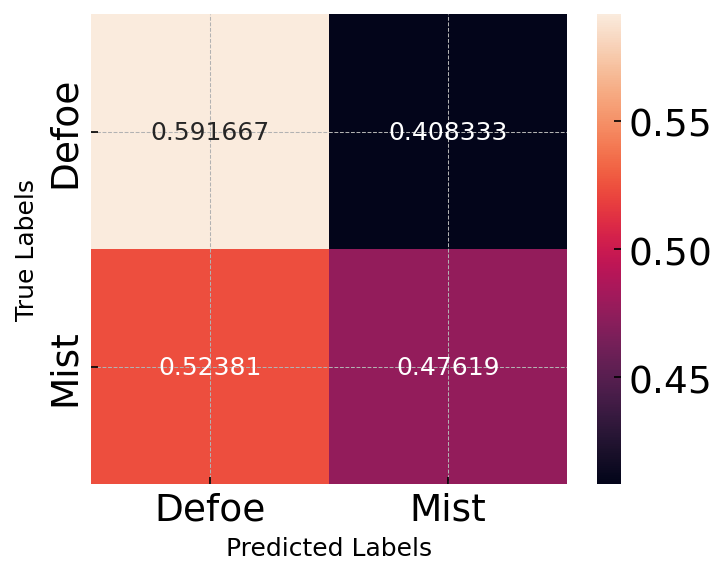

In [194]:
sns.heatmap(model_4_cmn, annot=True, fmt='g', xticklabels=['Defoe','Mist'], yticklabels=['Defoe','Mist'])
plt.xlabel('Predicted Labels', size = 12)
plt.ylabel('True Labels', size = 12)
plt.savefig('model_4.png')
plt.show()

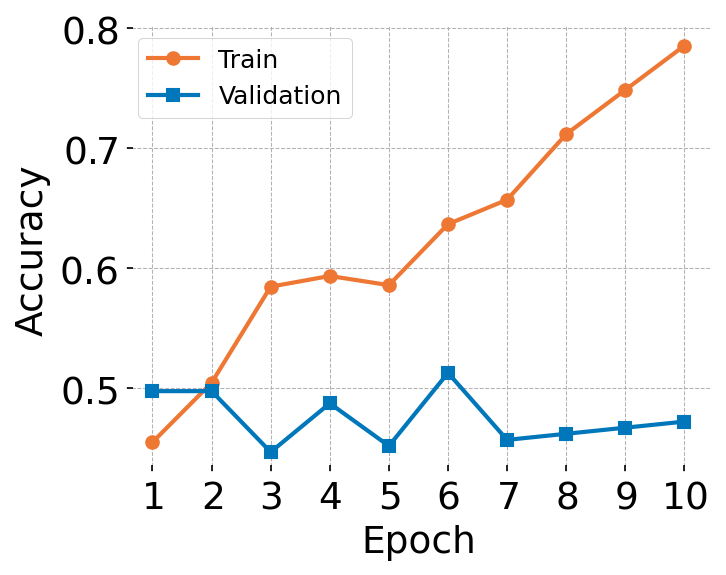

In [141]:
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(1,11,1))
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### See what happens for pyrates data

In [113]:
with open('model_data/pyrates.pkl','rb') as file:
    pyrates_sentences = pickle.load(file)

In [114]:
pyrates_tokens = tokenizer.texts_to_sequences(pyrates_sentences)

In [115]:
pyrates_tokens_padded = pad_sequences(pyrates_tokens, maxlen=max_len)

In [195]:
results = model_4.predict(pyrates_tokens_padded)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [196]:
results_id = np.argmax(results, axis=1)

In [197]:
np.unique(results_id, return_counts = True)

(array([0, 1]), array([626, 500]))

In [202]:
max_prob = []
for r in results:
    max_prob.append(np.max(r))

In [212]:
dist_1 = np.array(max_prob)[results_id==1]
dist_0 = np.array(max_prob)[results_id==0]

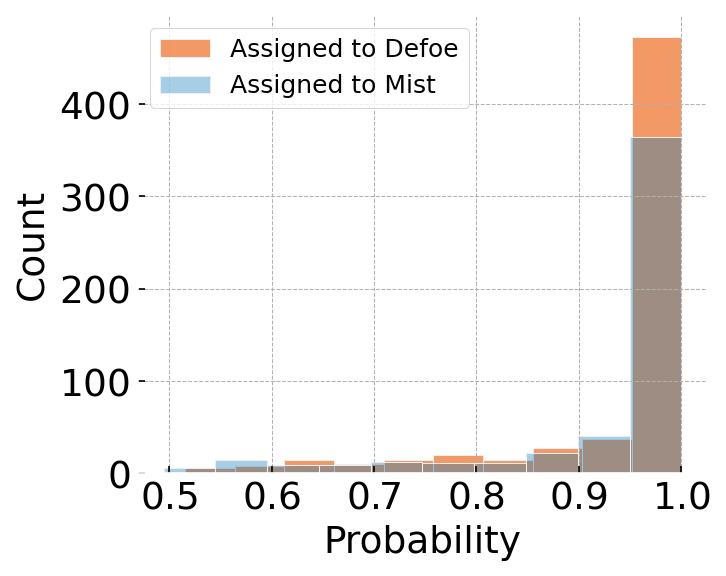

In [223]:
sns.histplot(dist_0, kde=False, label='Assigned to Defoe', bins=10, alpha=0.75)
sns.histplot(dist_1, kde=False, label='Assigned to Mist', bins=10, alpha=0.35)

# Add labels and legend
plt.xlabel('Probability')
plt.ylabel('Count')
plt.xticks([0.5,0.6,0.7,0.8,0.9,1])
plt.legend()